<a href="https://colab.research.google.com/github/jeehyun100/MTCNN/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libray Import

In [1]:
import numpy as np
import tensorflow as tf
import random
import gym
from collections import deque

# Colab drive Mount
### model file 저장하기 위해 본인의 google drive와 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Openai Gym 및 ipython display Setting
## colab에서 gym 환경을 plotting해서 볼수 있게 설정

In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

!apt-get install x11-utils > /dev/null 2>&1 and !pip install pyglet==v1.3.
!pip install gym --upgrade > /dev/null 2>&1
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
!pip install pyglet

# Cartpole 문제정의
## 이 게임은 손 위에 막대를 세워놓고, 막대가 쓰러지지 않도록 하는 게임입니다.

ㆍObservation : [x, θ, dx/dt, dθ/dt]
- x : track 상에서 cart의 위치
- θ : pole과 normal line과의 각도
- dx/dt : cart의 속도
- dθ/dt : θ의 각속도

ㆍEnding condition(of episode)
 1.   θ가 15˚이상
 2.   원점(O: cetroid of track)으로부터의 거리가 2.4 units이상 

ㆍAction : cart의 가하는 힘의 방향 (0 or 1)

ㆍReward : episode가 유지되는 시간

ㆍObjective : Ending condition을 피하며 reward를 최대로(pole의 균형을 오랫동안 유지)



action, state : 1 [-1.17407563 -0.84182596  4.15996045  8.39538282]
Input space 4
Output space(Action) 2


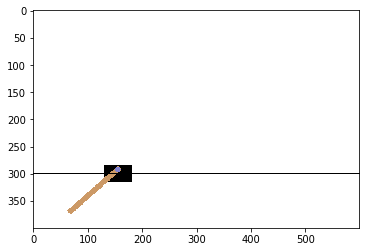

In [5]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0')
state = env.reset()
img = plt.imshow(env.render('rgb_array'))
with tf.Session() as sess:

    #mainDQN = DQN(sess, INPUT_SIZE, OUTPUT_SIZE)
    init = tf.global_variables_initializer()
    #mainDQN.load("dqn_v1")
    for _ in range(50):
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        #action = np.argmax(mainDQN.predict(state))
        print()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        print("action, state : {0} {1}".format(action,state ))
print("Input space {0}".format(env.observation_space.shape[0]))
print("Output space(Action) {0}".format(env.action_space.n))


# Make Deep Q Network
## Cart pole을 훈련 시킬 Deep Q Network를 만든다.

ㆍ_build_network
- Deep Nueral Network를 만드는 메소드
- input size : 4 -> hidden node size : 16 -> action size : 2

ㆍupdate
- Deep Learning Network를 훈련시키는 메소드

ㆍpredict
- state를 넣으면 action을 반환해주는 메소드

In [0]:
"""DQN Class

DQN(NIPS-2013)
"Playing Atari with Deep Reinforcement Learning"
https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

DQN(Nature-2015)
"Human-level control through deep reinforcement learning"
http://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
"""

class DQN:

    def __init__(self, session: tf.Session, input_size: int, output_size: int, name: str="main") -> None:
        """DQN Agent can

        1) Build network
        2) Predict Q_value given state
        3) Train parameters

        Args:
            session (tf.Session): Tensorflow session
            input_size (int): Input dimension
            output_size (int): Number of discrete actions
            name (str, optional): TF Graph will be built under this name scope
        """
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        

        self._build_network()
        self.saver = tf.train.Saver()

    def _build_network(self, h_size=16, l_rate=0.001) -> None:
        """DQN Network architecture (simple MLP)

        Args:
            h_size (int, optional): Hidden layer dimension
            l_rate (float, optional): Learning rate
        """
        with tf.variable_scope(self.net_name) as scope:

            self._X = tf.placeholder(tf.float32, [None, self.input_size], name="input_x")
            net = self._X

            net = tf.layers.dense(net, h_size, activation=tf.nn.relu)
            net = tf.layers.dense(net, self.output_size)
            self._Qpred = net

            self._Y = tf.placeholder(tf.float32, shape=[None, self.output_size])
            self._loss = tf.losses.mean_squared_error(self._Y, self._Qpred)

            optimizer = tf.train.AdamOptimizer(learning_rate=l_rate)
            self._train = optimizer.minimize(self._loss)
            scope.reuse_variables()

    def predict(self, state: np.ndarray) -> np.ndarray:
        """Returns Q(s, a)

        Args:
            state (np.ndarray): State array, shape (n, input_dim)

        Returns:
            np.ndarray: Q value array, shape (n, output_dim)
        """
        x = np.reshape(state, [-1, self.input_size])
        return self.session.run(self._Qpred, feed_dict={self._X: x})

    def update(self, x_stack: np.ndarray, y_stack: np.ndarray) -> list:
        """Performs updates on given X and y and returns a result

        Args:
            x_stack (np.ndarray): State array, shape (n, input_dim)
            y_stack (np.ndarray): Target Q array, shape (n, output_dim)

        Returns:
            list: First element is loss, second element is a result from train step
        """
        feed = {
            self._X: x_stack,
            self._Y: y_stack
        }
        return self.session.run([self._loss, self._train], feed)
     
    def save(self, file_path):
        """save 

        """
        self.saver.save(self.session, file_path)
        #saver.save(sess, checkpoint_path, global_step=step)
    def load(self, file_path):
        """save 

        """
        self.saver.restore(sess, file_path)
        print("load complete")
        #self.saver.save(self.session, file_path)
        #saver.save(sess, checkpoint_path, global_step=step)


# Initialize Parameters

## Openai gym 훈련용 환경을 만들고, 여러가지 기초정보를 세팅한다.

ㆍ DISCOUNT_RATE

ㆍ REPLAY_MEMORY : 훈련 경험을 저장하는 공간

ㆍ MAX_EPISODE : 훈련 횟수

ㆍ BATCH_SIZE : 한번에 훈련하는(BATCH) 단위(SIZE)


In [0]:

env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, 'gym-results/', force=True)
INPUT_SIZE = env.observation_space.shape[0]
OUTPUT_SIZE = env.action_space.n

DISCOUNT_RATE = 0.99
REPLAY_MEMORY = 50000
MAX_EPISODE = 700
BATCH_SIZE = 64

# minimum epsilon for epsilon greedy
MIN_E = 0.0
# epsilon will be `MIN_E` at `EPSILON_DECAYING_EPISODE`
EPSILON_DECAYING_EPISODE = MAX_EPISODE * 0.01

# 훈련 준비 코드
## train batch를 받가 DQN이 학습할수(update) 있게 전처리 하고 학습 결과(loss)를 반환한다.
ㆍ np.vstack : array를 세로로 붙이기
![대체 텍스트](https://t1.daumcdn.net/cfile/tistory/9909EF345D53F4D916)

ㆍ Target Q를 구하기 
- y_batch 는 reward + discount 팩처 * maxQ 아니면 게임종료(0)

ㆍ DQN.update(X_batch, y_batch) 
- X_batch는 현재 state
- Y_batch는 TargetQ 값



In [0]:
def train_minibatch(DQN: DQN, train_batch: list) -> float:
    """Prepare X_batch, y_batch and train them
    Recall our loss function is
        target = reward + discount * max Q(s',a)
                 or reward if done early
        Loss function: [target - Q(s, a)]^2
    Hence,
        X_batch is a state list
        y_batch is reward + discount * max Q
                   or reward if terminated early
    Args:
        DQN (dqn.DQN): DQN Agent to train & run
        train_batch (list): Minibatch of Replay memory
            Eeach element is a tuple of (s, a, r, s', done)
    Returns:
        loss: Returns a loss
    """
    state_array = np.vstack([x[0] for x in train_batch])
    action_array = np.array([x[1] for x in train_batch])
    reward_array = np.array([x[2] for x in train_batch])
    next_state_array = np.vstack([x[3] for x in train_batch])
    done_array = np.array([x[4] for x in train_batch])

    X_batch = state_array
    y_batch = DQN.predict(state_array)

    Q_target = reward_array + DISCOUNT_RATE * np.max(DQN.predict(next_state_array), axis=1) * ~done_array
    y_batch[np.arange(len(X_batch)), action_array] = Q_target

    # Train our network using target and predicted Q values on each episode
    loss, _ = DQN.update(X_batch, y_batch)

    return loss

In [0]:
def bot_play(mainDQN: DQN) -> None:
    """Runs a single episode with rendering and prints a reward
    Args:
        mainDQN (dqn.DQN): DQN Agent
    """
    state = env.reset()
    total_reward = 0

    while True:
        env.render()
        action = np.argmax(mainDQN.predict(state))
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            print("Total score: {}".format(total_reward))
            break

#  ε-Greedy or Annealiing epsilon
## ε를 구하는 다른 방법
시간이 지날수록 ε이 작아진다.

In [0]:
def annealing_epsilon(episode: int, min_e: float, max_e: float, target_episode: int) -> float:
    """Return an linearly annealed epsilon
    Epsilon will decrease over time until it reaches `target_episode`
         (epsilon)
             |
    max_e ---|\
             | \
             |  \
             |   \
    min_e ---|____\_______________(episode)
                  |
                 target_episode
     slope = (min_e - max_e) / (target_episode)
     intercept = max_e
     e = slope * episode + intercept
    Args:
        episode (int): Current episode
        min_e (float): Minimum epsilon
        max_e (float): Maximum epsilon
        target_episode (int): epsilon becomes the `min_e` at `target_episode`
    Returns:
        float: epsilon between `min_e` and `max_e`
    """

    slope = (min_e - max_e) / (target_episode)
    intercept = max_e

    return max(min_e, slope * episode + intercept)

# Main 함수
ㆍ MAX_EPISODE 만큼 훈련한다. 

ㆍ ε가 작으면 무작위 선택, 크면 Q에서 주는 값으로 행동한다.

ㆍ 선택된 액션을 하고, 다음 스테이트, 보상, 종료여부를 받는다.

ㆍ 게임이 끝나면 보상을 -1로 

ㆍ 아니면 replay memory에 상태, 행동, 보상, 다음상태, 종료여부를 넣는다

ㆍ 선택된 액션을 하고, 다음 스테이트, 보상, 종료여부를 받는다.

ㆍ 훈련할 데이터를 Batch size만큼 모으고, 그중 무작위 선택하여 DQN을 학습한다.

ㆍ 훈련된 모델을 저장한다.

In [0]:
def main():
    print("Start")
    # store the previous observations in replay memory
    replay_buffer = deque(maxlen=REPLAY_MEMORY)
    last_100_game_reward = deque(maxlen=100)

    with tf.Session() as sess:
        mainDQN = DQN(sess, INPUT_SIZE, OUTPUT_SIZE)
        init = tf.global_variables_initializer()
        sess.run(init)

        for episode in range(MAX_EPISODE):
            #e = 1./(( episode / 10) + 1)
            e = annealing_epsilon(episode, MIN_E, 1.0, EPSILON_DECAYING_EPISODE)
            done = False
            state = env.reset()

            step_count = 0
            while not done:

                if np.random.rand() < e:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(mainDQN.predict(state))

                next_state, reward, done, _ = env.step(action)

                if done:
                    reward = -1

                replay_buffer.append((state, action, reward, next_state, done))

                state = next_state
                step_count += 1

                if len(replay_buffer) > BATCH_SIZE:
                    minibatch = random.sample(replay_buffer, BATCH_SIZE)
                    train_minibatch(mainDQN, minibatch)

            print("[Episode {:>5}]  steps: {:>5} e: {:>5.2f}".format(episode, step_count, e))

            # CartPole-v0 Game Clear Logic
            last_100_game_reward.append(step_count)
            if len(last_100_game_reward) == last_100_game_reward.maxlen:
                avg_reward = np.mean(last_100_game_reward)
                if avg_reward > 199.0:
                    print("Game Cleared within {} episodes with avg reward {}".format(episode, avg_reward))
                    break
        mainDQN.save("dqn_v1")

## Main 함수실행

In [20]:
tf.reset_default_graph()
main()

Start
[Episode     0]  steps:    21 e:  1.00
[Episode     1]  steps:    10 e:  0.90
[Episode     2]  steps:    26 e:  0.80
[Episode     3]  steps:    43 e:  0.70
[Episode     4]  steps:    23 e:  0.60
[Episode     5]  steps:    12 e:  0.50
[Episode     6]  steps:    11 e:  0.40
[Episode     7]  steps:    10 e:  0.30
[Episode     8]  steps:    12 e:  0.20
[Episode     9]  steps:    10 e:  0.10
[Episode    10]  steps:    10 e:  0.00
[Episode    11]  steps:     9 e:  0.00
[Episode    12]  steps:     9 e:  0.00
[Episode    13]  steps:     9 e:  0.00
[Episode    14]  steps:     9 e:  0.00
[Episode    15]  steps:     8 e:  0.00
[Episode    16]  steps:    10 e:  0.00
[Episode    17]  steps:     8 e:  0.00
[Episode    18]  steps:    10 e:  0.00
[Episode    19]  steps:     8 e:  0.00
[Episode    20]  steps:     8 e:  0.00
[Episode    21]  steps:    10 e:  0.00
[Episode    22]  steps:    10 e:  0.00
[Episode    23]  steps:     9 e:  0.00
[Episode    24]  steps:    10 e:  0.00
[Episode    25]  st

# DQN 결과 보기
## 봉이 쓰러지지 않고 잘 서있으면 성공, 아니면 실패

In [0]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
init = tf.global_variables_initializer()
env = gym.make('CartPole-v0')
state = env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
tf.reset_default_graph()
with tf.Session() as sess:

    mainDQN = DQN(sess, INPUT_SIZE, OUTPUT_SIZE)
    init = tf.global_variables_initializer()
    mainDQN.load("dqn_v1")
    for _ in range(500):
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        #action = env.action_space.sample()
        action = np.argmax(mainDQN.predict(state))
        print()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        #print("action, state : {0} {1}".format(action,state ))
